In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# NumPy → signal creation
# Pandas → dataset storage
# Matplotlib → visualization

In [4]:
#GENERATE CLEAN RF SIGNAL
fs = 1000  # sampling frequency
t = np.linspace(0, 1, fs)

# Clean RF signal (sine wave)
signal_clean = np.sin(2 * np.pi * 50 * t)

In [5]:
# RF signal is represented as a sine wave
# 50 Hz = base frequency
# This is a non-interference signal

In [6]:
#ADD INTERFERENCE TYPES
# Narrowband interference
narrowband = signal_clean + 0.5 * np.sin(2 * np.pi * 200 * t)

# Broadband interference (noise)
broadband = signal_clean + np.random.normal(0, 0.5, fs)

# Impulsive interference (spikes)
impulsive = signal_clean.copy()
impulsive[np.random.randint(0, fs, 20)] += 2

In [7]:
# Narrowband → extra frequency
# Broadband → noise across frequencies
# Impulsive → sudden spikes

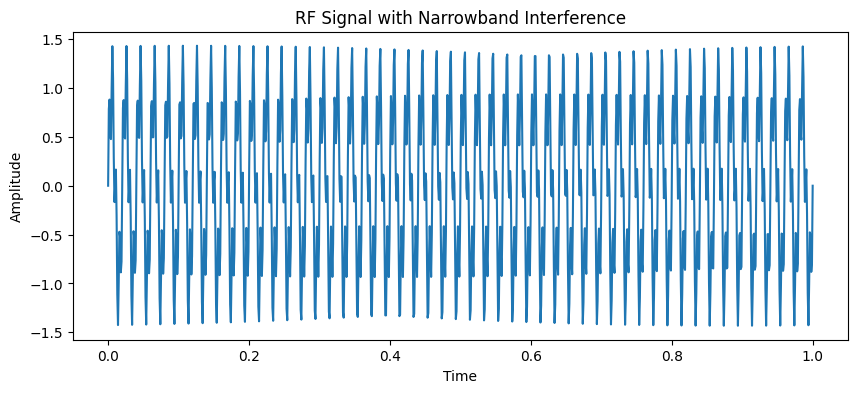

In [9]:
#VISULAIZING 
plt.figure(figsize=(10,4))
plt.plot(t, narrowband)
plt.title("RF Signal with Narrowband Interference")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
#This helps you see interference.

In [11]:
#DATA SET CREATION WITH LABELS
data = []

for i in range(fs):
    data.append([signal_clean[i], 0])   # No interference
    data.append([narrowband[i], 1])     # Narrowband
    data.append([broadband[i], 2])      # Broadband
    data.append([impulsive[i], 3])      # Impulsive

df = pd.DataFrame(data, columns=["signal_value", "label"])

In [12]:
# | Label | Meaning    |
# | ----- | ---------- |
# | 0     | Clean      |
# | 1     | Narrowband |
# | 2     | Broadband  |
# | 3     | Impulsive  |

In [17]:
import os

base_path = os.path.abspath("..")  # go one folder up
data_path = os.path.join(base_path, "data", "raw")

os.makedirs(data_path, exist_ok=True)

df.to_csv(os.path.join(data_path, "rfi_signal_dataset.csv"), index=False)